# Medical Insurance Cost Analysis

Author: Sylas Chacko

Date: 10/18/2024

### Imports & Data Reading

In [18]:
# Imports
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
rs = 42

In [3]:
df = pd.read_csv(r'insurance_data.csv')

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### Data Cleaning & Preprocessing

- Missing Values
- Duplicates
- One-Hot-Encoding
- Scaling Data

In [5]:
# Check for missing values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
# Checking for duplicate rows
duplicates = df.duplicated()

# Count and print the number of duplicate rows
num_dup = duplicates.sum()
print("Number of duplicate rows:{}".format(num_dup))


Number of duplicate rows:1


In [7]:
# Keeps the first occurance and removes duplicate rows
df1 = df.drop_duplicates()

In [8]:
# Checking for duplicate rows
duplicates = df1.duplicated()

# Count and print the number of duplicate rows
num_dup = duplicates.sum()
print("Number of duplicate rows:{}".format(num_dup))


Number of duplicate rows:0


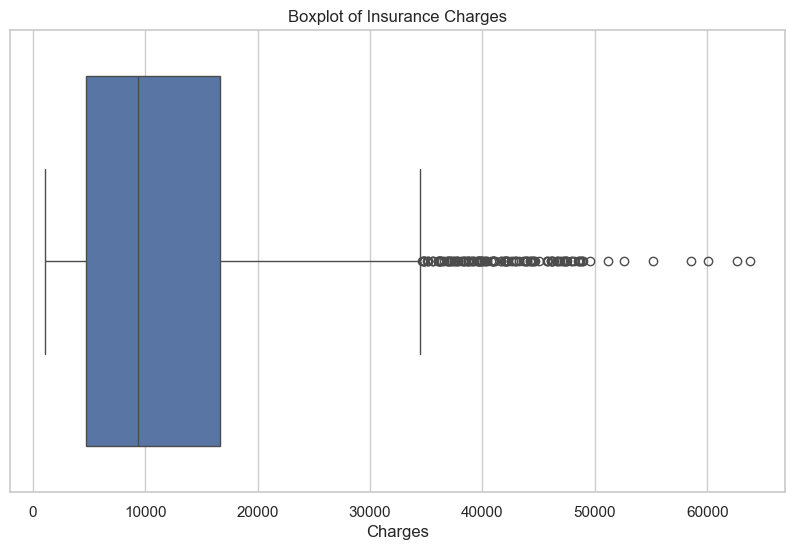

In [9]:
# Checking outliers
sns.set_theme(style='whitegrid')


plt.figure(figsize=(10,6))
sns.boxplot(x=df1['charges'])

#Plot Title & Lables
plt.title('Boxplot of Insurance Charges')
plt.xlabel('Charges')

plt.show()



It seems that there are many outliers that are outside of Q4. This graph shows that much of the data is above Q3 + 1.5 * IQR. I will have to test the model performance with many different approaches to the outliers and conclude with the best performing model. Each new approach to outliers will have it's individual pros and cons. Outlier analysis for each model is included in the documentation.

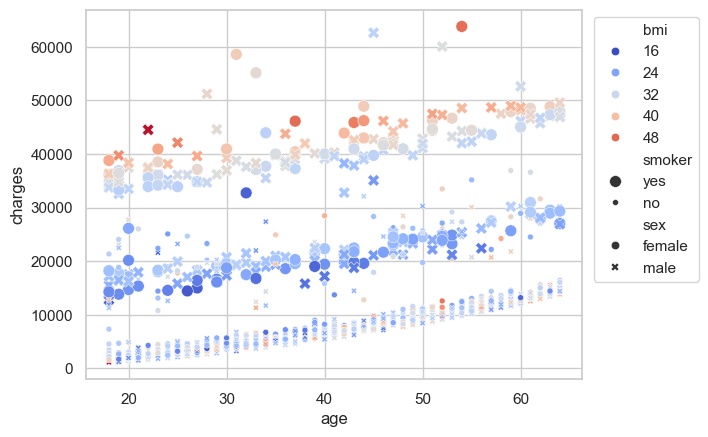

In [14]:
# Create the scatter plot
sns.scatterplot(x='age', y='charges', 
                hue='bmi', size='smoker', style ='sex',
                palette = 'coolwarm', data=df1)

plt.legend(bbox_to_anchor =(1.25,1),
           loc = 'upper right')
# Show the plot
plt.show()


This graph show's that the outliers in the dataset can be considered valid. There are general observable trends in this graph. Higher charges are correlated with older ages, higher bmi's, and smokers. If higher charges were correlated with low bmi, younger ages, and peope who do not smoke, then this would be grounds for removing outliers.

In [16]:
# One-Hot-Encoding
df2 = pd.get_dummies(df1, prefix={'sex':'sex','smoker':'smoker','region':'region'}, 
               prefix_sep="_", 
               columns=['sex','smoker','region'],
               dtype=int)

df2.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


In [21]:
X = df2.drop(columns=['charges'])
y = df2['charges']

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, 
                                         random_state = rs)

In [24]:
# Scaling data
scaler = StandardScaler()

# Columns to standardize
columns_to_scale = ['age', 'bmi']

# Fitting and Transforming the data
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])


# First few rows
print(X_train[columns_to_scale].head())
print(X_test[columns_to_scale].head())


           age       bmi
1114 -1.157680 -0.996928
968  -1.300619 -0.792762
599   0.914926  1.154664
170   1.701087  1.806837
275   0.557580 -0.651417
           age       bmi
900   0.680704 -1.378622
1064 -0.725297 -0.886324
1256  0.821304  0.834723
298  -0.584697  0.516365
237  -0.584697  1.154677
